In [19]:
# === STEP 1: Import Library ===
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2hsv

In [20]:
# === STEP 2: Fungsi Menampilkan Gambar ===
def show_image(title, image):
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image.astype(np.uint8))
    plt.show()

In [21]:
# === STEP 3: Konversi Warna ===
def convert_bgr_to_rgb(image):
    return image[..., ::-1]

def convert_rgb_to_hsv(image_rgb):
    rgb_normalized = image_rgb.astype(np.float32) / 255.0
    hsv = rgb2hsv(rgb_normalized)
    h = (hsv[..., 0] * 179).astype(np.uint8)
    s = (hsv[..., 1] * 255).astype(np.uint8)
    v = (hsv[..., 2] * 255).astype(np.uint8)
    return np.stack([h, s, v], axis=-1)

def convert_rgb_to_grayscale(image_rgb):
    r, g, b = image_rgb[..., 0], image_rgb[..., 1], image_rgb[..., 2]
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    return np.clip(gray, 0, 255).astype(np.uint8)

In [22]:
# === STEP 4: Gaussian Blur Manual ===
def create_gaussian_kernel(size, sigma=1):
    ax = np.linspace(-(size // 2), size // 2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def manual_convolve(image, kernel):
    if image.ndim == 2:
        return convolve_single(image, kernel)
    else:
        return np.stack([convolve_single(image[..., i], kernel) for i in range(3)], axis=-1)

def convolve_single(image, kernel):
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2
    padded = np.pad(image, ((ph, ph), (pw, pw)), mode='reflect')
    result = np.zeros_like(image, dtype=np.float32)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            result[i, j] = np.sum(region * kernel)
    return np.clip(result, 0, 255).astype(np.uint8)

In [23]:
# === STEP 5: Deteksi Warna Manual ===
def in_range(hsv, lower, upper):
    return (
        (hsv[..., 0] >= lower[0]) & (hsv[..., 0] <= upper[0]) &
        (hsv[..., 1] >= lower[1]) & (hsv[..., 1] <= upper[1]) &
        (hsv[..., 2] >= lower[2]) & (hsv[..., 2] <= upper[2])
    )

def get_red_mask_manual(hsv):
    lower1 = np.array([0, 50, 50])
    upper1 = np.array([10, 255, 255])

    lower2 = np.array([160, 50, 50])
    upper2 = np.array([180, 255, 255])

    mask1 = in_range(hsv, lower1, upper1)
    mask2 = in_range(hsv, lower2, upper2)
    return (mask1 | mask2).astype(np.uint8)

def get_white_mask_manual(hsv):
    # Gabungan beberapa opsi deteksi putih: terang, abu terang, dan luas
    lower1 = np.array([0, 0, 180])
    upper1 = np.array([180, 30, 255])

    lower2 = np.array([0, 0, 90])
    upper2 = np.array([180, 60, 255])

    lower3 = np.array([0, 0, 120])
    upper3 = np.array([180, 70, 255])

    mask1 = in_range(hsv, lower1, upper1)
    mask2 = in_range(hsv, lower2, upper2)
    mask3 = in_range(hsv, lower3, upper3)

    return (mask1 | mask2 | mask3).astype(np.uint8)

In [24]:
# === STEP 6: Operasi Morfologi Manual ===
def erode(mask, kernel):
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2
    padded = np.pad(mask, ((ph, ph), (pw, pw)), mode='constant', constant_values=0)
    result = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            result[i, j] = np.min(region[kernel == 1])
    return result

def dilate(mask, kernel):
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2
    padded = np.pad(mask, ((ph, ph), (pw, pw)), mode='constant', constant_values=0)
    result = np.zeros_like(mask)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            region = padded[i:i+kh, j:j+kw]
            result[i, j] = np.max(region[kernel == 1])
    return result

def open_morph(mask, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    return dilate(erode(mask, kernel), kernel)

def close_morph(mask, kernel_size=5):
    kernel = np.ones((kernel_size, kernel_size), dtype=np.uint8)
    return erode(dilate(mask, kernel), kernel)

def clean_mask(mask, kernel_size=5):
    opened = open_morph(mask, kernel_size)
    closed = close_morph(opened, kernel_size)
    return closed

In [52]:
def label_manual(mask):
    """
    Melakukan connected component labeling secara manual (4-neighborhood).
    Input: binary mask (0 dan 1)
    Output: labeled_mask (tiap objek diberi label unik), num_labels
    """
    labeled = np.zeros_like(mask, dtype=np.int32)
    label_id = 1
    height, width = mask.shape

    def dfs(x, y):
        stack = [(x, y)]
        while stack:
            i, j = stack.pop()
            if (0 <= i < height and 0 <= j < width and
                mask[i, j] == 1 and labeled[i, j] == 0):
                labeled[i, j] = label_id
                # 4-neighborhood (atas, bawah, kiri, kanan)
                stack.extend([
                    (i-1, j), (i+1, j),
                    (i, j-1), (i, j+1)
                ])

    for i in range(height):
        for j in range(width):
            if mask[i, j] == 1 and labeled[i, j] == 0:
                dfs(i, j)
                label_id += 1

    return labeled, label_id - 1


In [66]:
# === STEP 7: Deteksi Bentuk Bundar Manual (Elliptical Approximation via Eccentricity) ===
def detect_circular_object(mask):
    labeled_mask, num_labels = label_manual(mask)
    print(f"Total objek ditemukan: {num_labels}")

    for label_id in range(1, num_labels + 1):
        region = (labeled_mask == label_id)
        y, x = np.nonzero(region)

        if len(x) >= 5:
            x_mean, y_mean = np.mean(x), np.mean(y)
            x_norm = x - x_mean
            y_norm = y - y_mean
            coords = np.stack([x_norm, y_norm])
            cov = np.cov(coords)
            eigvals = np.linalg.eigvalsh(cov)

            if eigvals[1] != 0:
                ratio = eigvals[0] / eigvals[1] if eigvals[0] < eigvals[1] else eigvals[1] / eigvals[0]
                print(f"Label {label_id}: rasio = {ratio:.2f}, eigvals = {eigvals}, pixel = {len(x)}")
                if ratio > 0.3:
                  return True
    return False


In [72]:
# === STEP 8: Pipeline Utama ===
def process_image(image):
    rgb = convert_bgr_to_rgb(image)
    hsv = convert_rgb_to_hsv(rgb)

    show_image("Gambar RGB", rgb)

    red_mask = get_red_mask_manual(hsv)
    white_mask = get_white_mask_manual(hsv)

    red_clean = clean_mask(red_mask)
    white_in_red = white_mask * red_clean

    # Terapkan morfologi manual (closing) untuk mengisi area putih
    white_in_red = close_morph(white_in_red, kernel_size=35)

    show_image("Red Clean", red_clean * 255)
    show_image("White in Red", white_in_red * 255)

    combined_mask = np.clip(red_clean + white_in_red, 0, 1)
    show_image("Combined Mask", combined_mask * 255)

    combined_clean = clean_mask(combined_mask)
    show_image("Combined Mask Akhir", combined_clean * 255)

    mask_inv = 1 - combined_clean
    fg = (rgb * combined_clean[..., None]).astype(np.uint8)
    bg = (rgb * mask_inv[..., None]).astype(np.uint8)

    kernel = create_gaussian_kernel(11, sigma=5)
    bg_blur = manual_convolve(bg, kernel)
    result = np.clip(fg + bg_blur, 0, 255).astype(np.uint8)

    is_prohibited = detect_circular_object(red_clean)
    return result, is_prohibited

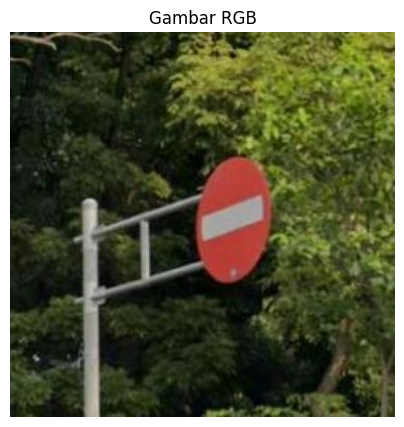

Jumlah piksel merah terdeteksi: 7619


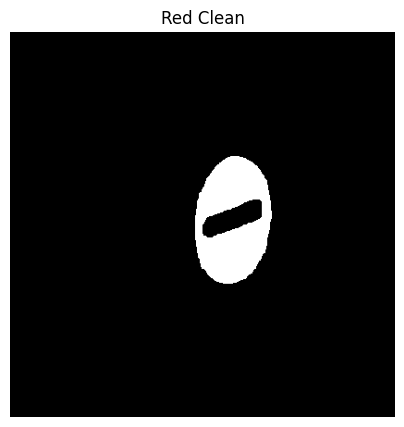

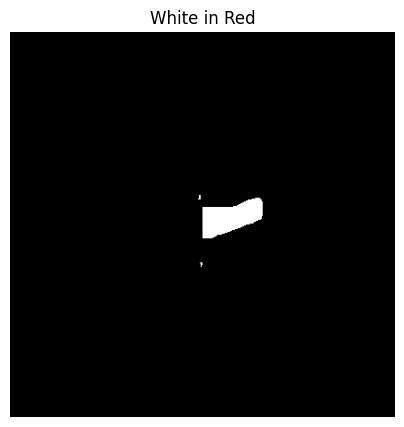

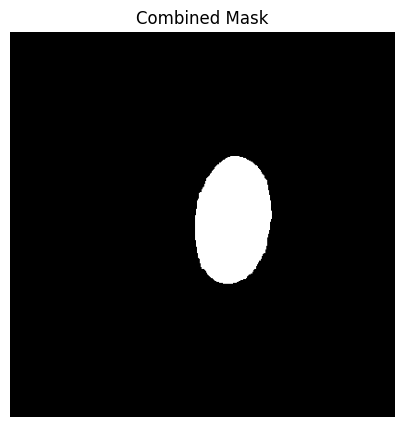

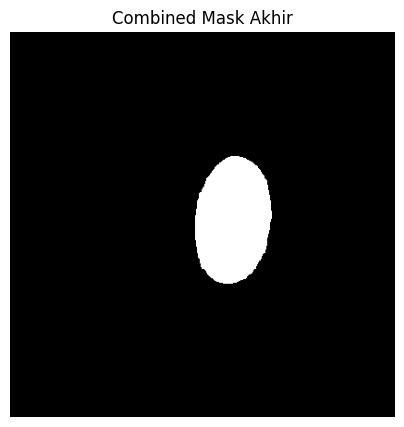

Total objek ditemukan: 1
Label 1: rasio = 0.31, eigvals = [ 447.04386131 1421.19652911], pixel = 7579


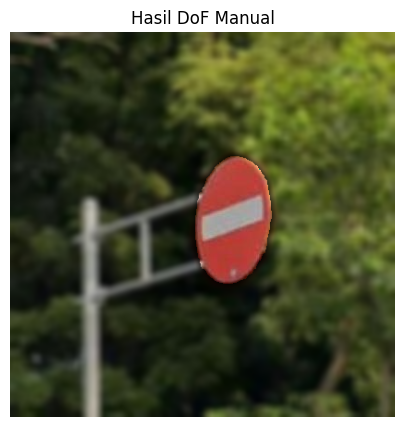

Terdeteksi: Rambu Dilarang


In [75]:
# === STEP 9: Contoh Eksekusi ===
img = cv2.imread('/content/larangan_masuk.jpg')
output, is_prohibited = process_image(img)
show_image("Hasil DoF Manual", output)
print("Terdeteksi: Rambu Dilarang" if is_prohibited else "Bukan rambu dilarang")